# From Vanilla RNN to Transformer

## Importations, connexion to Google Drive, set working directory

**Importations**

In [36]:
import os

import pickle

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from torch.utils.tensorboard import SummaryWriter

**Mounting drive**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

**Setting working directory**

In [2]:
wd = 'drive/MyDrive/KTH/DD2424 - Deep Learning for Data Science/Project/text-generation-project/Notebook'

os.chdir(wd)

## Dataset

In [3]:
class CustomDataset(Dataset):
  def __init__(self, file_path, seq_length):
    self.seq_length = seq_length
    with open(file_path, 'r') as f:
      self.book_data = f.read()
    self.book_chars = list(set(self.book_data))
    self.vocab_size = len(self.book_chars)
    self.char_to_ind = {key: i for i, key in enumerate(self.book_chars)}
    self.ind_to_char = {i: key for i, key in enumerate(self.book_chars)}

  def __getitem__(self, idx):
    e = idx*self.seq_length
    if e < len(self.book_data) - self.seq_length:
      inputs = self.encode(self.book_data[e : e + self.seq_length])
      outputs = self.encode(self.book_data[e + 1 : e + self.seq_length + 1])
      return inputs, outputs

  def __len__(self):
    return len(self.book_data) // self.seq_length

  def encode(self, inputs):
    res = torch.zeros(len(inputs), self.vocab_size)
    col_indices = [self.char_to_ind[c] for c in inputs]
    row_indices = np.arange(len(inputs))
    res[row_indices, col_indices] = 1
    return res

### Creation train/val/test dataset

In [4]:
# Create Dataset
file_path = 'goblet_book.txt'
seq_length = 25
dataset = CustomDataset(file_path, seq_length)

# Split train 70%/val 15%/test 15%
train_index = int(0.7 * len(dataset))
val_index = len(dataset) - int(0.15 * len(dataset))
train_indices = torch.arange(train_index)
val_indices = torch.arange(train_index, val_index)
test_indices = torch.arange(val_index, len(dataset))

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# # Create DataLoader
# train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=False)
# test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

**To check the split is correct**

In [52]:
x_batch, y_batch = train_dataset.__getitem__(0)
print(''.join([dataset.ind_to_char[ind.item()] for ind in torch.argmax(x_batch, dim=1)]))

x_batch, y_batch = train_dataset.__getitem__(len(train_dataset)-1)
print(''.join([dataset.ind_to_char[ind.item()] for ind in torch.argmax(x_batch, dim=1)]))

x_batch, y_batch = val_dataset.__getitem__(0)
print(''.join([dataset.ind_to_char[ind.item()] for ind in torch.argmax(x_batch, dim=1)]))

x_batch, y_batch = val_dataset.__getitem__(len(val_dataset)-1)
print(''.join([dataset.ind_to_char[ind.item()] for ind in torch.argmax(x_batch, dim=1)]))

x_batch, y_batch = test_dataset.__getitem__(0)
print(''.join([dataset.ind_to_char[ind.item()] for ind in torch.argmax(x_batch, dim=1)]))

x_batch, y_batch = test_dataset.__getitem__(len(test_dataset)-1)
print(''.join([dataset.ind_to_char[ind.item()] for ind in torch.argmax(x_batch, dim=1)]))

HARRY POTTER AND THE GOBL
e. . . dear, dear.  Potte
r, what's ailing you now?
 was silence.  He stared 
all around him.  What had
and he would have to meet


## RNN

### class

In [5]:
class VanillaRNN(nn.Module):
  def __init__(self, hidden_size, vocab_size, seq_length):
    super().__init__()
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size

    self.rnn = nn.RNN(input_size=vocab_size,
                      hidden_size=hidden_size,
                      num_layers=1,
                      nonlinearity='tanh',
                      bias=True)
    self.fc = nn.Linear(hidden_size, vocab_size)

  def forward(self, x, h0):
    h, ht = self.rnn(x, h0)
    o = self.fc(h)
    return o, ht

  def synthetize(self, xt, ht_1, n, ind_to_char):
    text = ''
    for i in range(n):
      with torch.no_grad():
        h, ht_1 = self.rnn(xt, ht_1)
        o = self.fc(h)
        p = torch.softmax(o, dim=1)
        ii = torch.multinomial(p.squeeze(), 1)
        xt = torch.zeros_like(xt)
        xt[0,ii] = 1
        text += ind_to_char[ii.item()]

    print(text, '\n')

  def loss_fct(self, o, y_true):
    probabilities = torch.softmax(o, dim=1)
    col_indices = torch.argmax(y_true, dim=1)
    row_indices = torch.arange(y_true.shape[0])
    return - torch.sum(torch.log(probabilities[row_indices, col_indices]))

### Training

In [17]:
#- Parameters
hidden_size = 100
vocab_size = dataset.vocab_size

# #- Tensorboard
# writer = SummaryWriter(log_dir='runs/exp4')

#- Make use of GPU if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#- Defining the model
model = VanillaRNN(hidden_size, vocab_size, seq_length).to(device)

#- Defining the optimizer
optimizer = optim.Adagrad(model.parameters(), lr=0.1)

#- Training loop
n_epochs = 10
iteration = 0
training_loss_RNN = []
validation_loss_RNN = []
pbar1 = tqdm(range(n_epochs), total=n_epochs, position=0, leave=True)
for epoch in pbar1:
  # evaluation
  with torch.no_grad():
    val_loss = 0
    hprev = torch.zeros(1, hidden_size).to(device)
    for j, (x_val, y_val) in enumerate(val_dataset):
      model.eval()
      x_val, y_val = x_val.to(device), y_val.to(device)
      o_val, hprev = model(x_val, hprev)
      val_loss += model.loss_fct(o_val, y_val).item()
    val_loss /= len(val_dataset)
    validation_loss_RNN.append(val_loss)

  hprev = torch.zeros(1, hidden_size).to(device)
  pbar2 = tqdm(enumerate(train_dataset), total=len(train_dataset), position=1, leave=False)
  for i, (x_batch, y_batch) in pbar2:
    model.train()

    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    o_batch, hprev = model(x_batch, hprev.detach())

    optimizer.zero_grad()
    loss = model.loss_fct(o_batch, y_batch)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
    optimizer.step()

    if iteration==0:
      smooth_loss = loss.item()
    else:
      smooth_loss = 0.999*smooth_loss + 0.001*loss.item()
    training_loss_RNN.append(smooth_loss)

    # if iteration%500==0:
    #   print(f'iter = {iteration}, smooth_loss = {smooth_loss}')
    #   model.synthetize(x_batch[0:1], hprev, 200, dataset.ind_to_char)

    # writer.add_scalar('Smooth loss', smooth_loss, iteration)
    # writer.flush()

    iteration+=1

# writer.close()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

In [ ]:
with open('training_loss_rnn.pkl', 'wb') as f:
    pickle.dump(training_loss_RNN, f)
with open('validation_loss_rnn.pkl', 'wb') as f:
    pickle.dump(validation_loss_RNN, f)

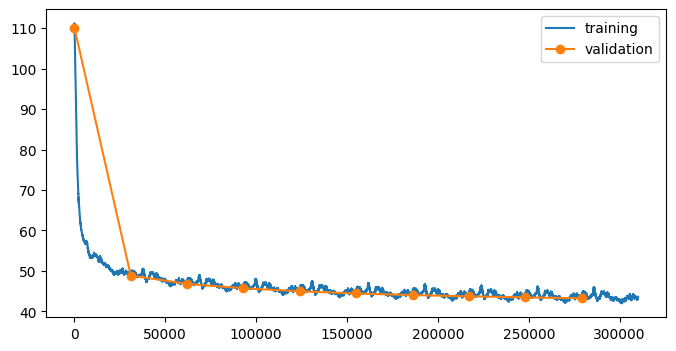

In [22]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(iteration), training_loss_RNN, label='training')
plt.plot(len(train_dataset)*np.arange(n_epochs), np.array(validation_loss_RNN), '-o', label='validation')
plt.legend()
plt.show()

## LSTM

### class

In [23]:
class LSTM(nn.Module):
  def __init__(self, hidden_size, vocab_size, seq_length):
    super().__init__()
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size=vocab_size,
                        hidden_size=hidden_size,
                        num_layers=1,
                        batch_first=True)
    self.fc = nn.Linear(hidden_size, vocab_size)

  def forward(self, x, h0, c0):
    h, (ht, ct) = self.lstm(x, (h0, c0))
    y = self.fc(h)
    return y, ht, ct

  def synthetize(self, ht_1, ct_1, xt, n, ind_to_char):
    text = ''
    for t in range(n):
      with torch.no_grad():
        h, (ht_1, ct_1) = self.lstm(xt, (ht_1, ct_1))
        yt = self.fc(h)
        probabilities = torch.softmax(yt, dim=1)
        ii = torch.multinomial(probabilities.squeeze(), 1)
        xt = torch.zeros_like(xt)
        xt[0][ii] = 1
        text += ind_to_char[ii.item()]

    print(text, '\n')

  def loss_fct(self, outputs, y_true):
    probabilities = torch.softmax(outputs, dim=1)
    col_indices = torch.argmax(y_true, dim=1)
    row_indices = torch.arange(y_true.shape[0])
    return - torch.sum(torch.log(probabilities[row_indices, col_indices]))

### Training

In [24]:
#- Parameters
hidden_size = 100
vocab_size = dataset.vocab_size

# #- Tensorboard
# writer = SummaryWriter(log_dir='runs/exp2')

#- Make use of GPU if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

#- Defining model
model_lstm = LSTM(hidden_size, vocab_size, seq_length).to(device)

#- Defining optimizer
optimizer = torch.optim.Adagrad(model_lstm.parameters(), lr=0.1)

#- Training loop
n_epochs = 10
iteration = 0
training_loss_lstm = []
validation_loss_lstm = []
pbar1 = tqdm(range(n_epochs), total=n_epochs, position=0, leave=True)
for epoch in pbar1:
  with torch.no_grad():
    val_loss = 0
    hprev = torch.zeros(1, hidden_size).to(device)
    cprev = torch.zeros(1, hidden_size).to(device)
    for j, (x_val, y_val) in enumerate(val_dataset):
      model_lstm.eval()
      x_val, y_val = x_val.to(device), y_val.to(device)
      o_val, hprev, cprev = model_lstm(x_val, hprev, cprev)
      val_loss += model_lstm.loss_fct(o_val, y_val).item()
    val_loss /= len(val_dataset)
    validation_loss_lstm.append(val_loss)

  hprev = torch.zeros(1, hidden_size).to(device)
  cprev = torch.zeros(1, hidden_size).to(device)
  pbar2 = tqdm(enumerate(train_dataset), total=len(train_dataset), position=1, leave=False)
  for i, (x_batch, y_batch) in pbar2:
    model_lstm.train()

    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    y_pred, hprev, cprev = model_lstm(x_batch, hprev.detach(), cprev.detach())

    optimizer.zero_grad()
    loss = model_lstm.loss_fct(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    if iteration==0:
      smooth_loss = loss.item()
    else:
      smooth_loss = 0.999*smooth_loss + 0.001*loss.item()
    training_loss_lstm.append(smooth_loss)

    # if iteration%500==0:
    #   print(f"iter: {iteration}, smooth loss: {smooth_loss}")
    #   model_lstm.synthetize(hprev, cprev, x_batch[0:1], 200, dataset.ind_to_char)

    # writer.add_scalar('Smooth loss', smooth_loss, iteration)
    # writer.flush()

    iteration += 1
# writer.close()

cpu


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

  0%|          | 0/31010 [00:00<?, ?it/s]

In [ ]:
with open('training_loss_lstm.pkl', 'wb') as f:
    pickle.dump(training_loss_lstm, f)
with open('validation_loss_lstm.pkl', 'wb') as f:
    pickle.dump(validation_loss_lstm, f)

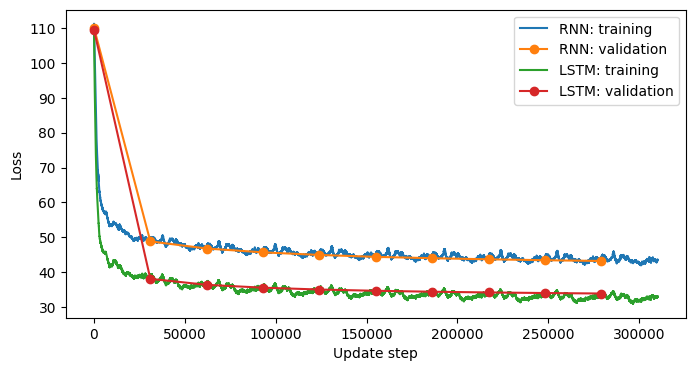

In [28]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(iteration), training_loss_RNN, label='RNN: training')
plt.plot(len(train_dataset)*np.arange(n_epochs), np.array(validation_loss_RNN), '-o', label='RNN: validation')
plt.plot(np.arange(iteration), training_loss_lstm, label='LSTM: training')
plt.plot(len(train_dataset)*np.arange(n_epochs), np.array(validation_loss_lstm), '-o', label='LSTM: validation')
plt.ylabel('Loss')
plt.xlabel('Update step')
plt.legend()
plt.show()

# GitHub command

In [38]:
!git pull

From https://github.com/PierreFalconnier/text-generation-project
   c09206f..ced6fd2  karim-branch -> origin/karim-branch
There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> michel-branch



In [37]:
!git status

Refresh index: 100% (14/14), done.
On branch michel-branch
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Project.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	shakespeare.txt
	training_loss_lstm.pkl
	training_loss_rnn.pkl
	validation_loss_lstm.pkl
	validation_loss_rnn.pkl

no changes added to commit (use "git add" and/or "git commit -a")


In [31]:
!git config --global user.email "ldzmichel@gmail.com" store
!git config --global user.name "MichelLDZ" store

In [25]:
!git commit -m "Add my notebook, containing the Dataset, RNN and LSTM classes. Added the text file goblet_book.txt"

[michel-branch f675495] Add my notebook, containing the Dataset, RNN and LSTM classes. Added the text file goblet_book.txt
 2 files changed, 6378 insertions(+)
 create mode 100644 Notebook/Project.ipynb
 create mode 100644 Notebook/goblet_book.txt


In [33]:
# !git config --global credential.helper store

In [35]:
!git branch

  main
* michel-branch


To see if there is anything new:

In [39]:
!git fetch origin

In [ ]:
!git checkout michel-branch
!git rebase origin/main

In [ ]:
!git rebase --continue

In [ ]:
!git push

# Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs